Title

In [26]:
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 8)

In [27]:
set.seed(38)

Introduction

Preliminary exploratory data analysis

In [28]:
## Load datasets from URL

algerian_forest_fire_Bejaia <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", 
                                 skip = 1, n_max = 122) %>%
    mutate(Region = "Bejaia")

algerian_forest_fire_Sidi_Bel_Abbes <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv",
                                               skip = 126) %>%
    mutate(Region = "Sidi Bel Abbes")

## Merge datasets of the two regions

algeria_forest_fire_all_data <- rbind(algerian_forest_fire_Bejaia, algerian_forest_fire_Sidi_Bel_Abbes) %>%
    mutate(Classes = as_factor(Classes)) %>%
    mutate(Region = as_factor(Region))

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_character(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“1 parsing failure.
row col   expected     actual                                                                                                       file
 44  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-lear

In [29]:
## Manually set values of incorrect column, convert DC and FWI to numeric type

algeria_forest_fire_all_data[166, 10] <- '14.6'
algeria_forest_fire_all_data[166, 11] <- 9
algeria_forest_fire_all_data[166, 12] <- 12.5
algeria_forest_fire_all_data[166, 13] <- '10.4'
algeria_forest_fire_all_data[166, 14] <- "fire" 

algeria_forest_fire_all_data <- algeria_forest_fire_all_data %>%
    mutate(DC = as.numeric(DC)) %>%
    mutate(FWI = as.numeric(FWI))

# ## Create date column
# algeria_forest_fire_all_data <- algeria_forest_fire_all_data %>%
#     mutate(date = as.Date(paste(year, month, day, sep='-')))

In [30]:
## Create training dataset

forest_fire_split <- algeria_forest_fire_all_data %>%
    select(Temperature, RH, Rain, FFMC, Classes) %>%
    initial_split(prop = 0.65, strata = Classes)
forest_fire_train <- training(forest_fire_split)
forest_fire_test <- testing(forest_fire_split)

forest_fire_train

Temperature,RH,Rain,FFMC,Classes
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,57,0.0,65.7,not fire
29,61,1.3,64.4,not fire
26,82,13.1,47.1,not fire
25,89,2.5,28.6,not fire
⋮,⋮,⋮,⋮,⋮
30,65,0.0,85.4,fire
28,87,4.4,41.1,not fire
27,87,0.5,45.9,not fire
24,54,0.1,79.7,not fire


The following table summarizes the predictors means' and the number of observations for each of the classes. We see that the classes are approximately balanced, with more observations of fire than no fire. Compared to days with no fire, temperature is slightly higher, relative humidity is lower, the Fine Fuel Moisture Code is higher, and there appears to be very little rain on days with fire.

In [31]:
## Explore means of predictor variables and the number of observations in each category

means <- forest_fire_train %>%
    group_by(Classes) %>%
    summarize(mean_temp = mean(Temperature),
             mean_RH = mean(RH),
             mean_rain = mean(Rain),
             mean_FFMC = mean(FFMC),
             obs_count = n())

means

`summarise()` ungrouping output (override with `.groups` argument)



Classes,mean_temp,mean_RH,mean_rain,mean_FFMC,obs_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
not fire,29.75362,69.92754,1.65652174,64.85072,69
fire,33.85556,56.26667,0.04888889,87.47889,90


We also show the minimum and maximum values of the predictors in cases of fire and no fire. The ranges of the temperature and relative humidity appear similar, but interestingly, fire never occurred on a day with rainfall more than 0.6 mm. Furthermore, observations in the "fire" class have FFMC ranging from 80.2 to 96.0, whereas observations in the "not fire" class have FFMC ranging from 28.6 to 81.1. This suggests that FFMC may be an excellent predictor of fire, with FFMC ≈ 80 serving as a boundary between the two classes.

In [32]:
## Explore max values of predictor variables

maxima <- forest_fire_train %>%
    group_by(Classes) %>%
    summarize(max_temp = max(Temperature),
             max_RH = max(RH),
             max_Rain = max(Rain),
             max_FFMC = max(FFMC))

maxima

`summarise()` ungrouping output (override with `.groups` argument)



Classes,max_temp,max_RH,max_Rain,max_FFMC
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
not fire,38,89,16.8,81.1
fire,42,88,0.6,96.0


In [33]:
## Explore min values of predictor variables

minima <- forest_fire_train %>%
    group_by(Classes) %>%
    summarize(min_temp = min(Temperature),
             min_RH = min(RH),
             min_Rain = min(Rain),
             min_FFMC = min(FFMC))

minima

`summarise()` ungrouping output (override with `.groups` argument)



Classes,min_temp,min_RH,min_Rain,min_FFMC
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
not fire,22,45,0,28.6
fire,26,21,0,80.2


In [34]:
options(repr.plot.width = 8, repr.plot.height = 6)

Next, we would like to explore in more detail how the frequency distribution of each predictor variable compares between the 2 classes. In particular, we would like to examine differences in the distributions, which would suggest how each variable can act as a predictor of fire.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



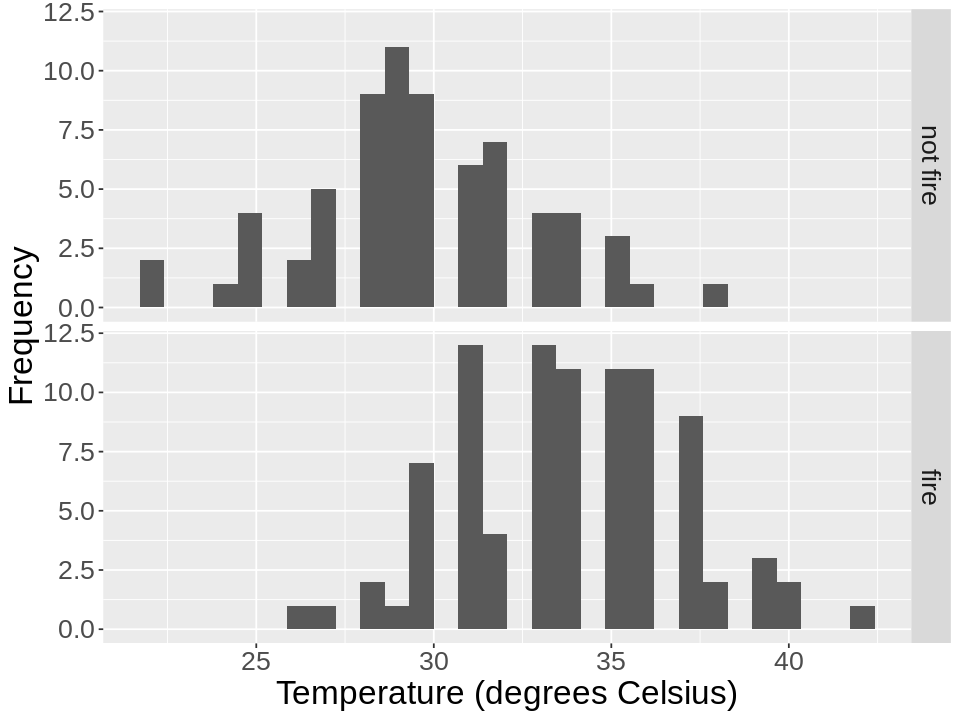

In [35]:
## Plot distribution of 'temperature' predictor on days with and without fire

temp_distribution_plot_fire <- forest_fire_train %>%
    ggplot(aes(x = Temperature)) +
    geom_histogram() +
    labs(x = "Temperature (degrees Celsius)", y = "Frequency") +
    facet_grid(Classes ~ .) +
    theme(text = element_text(size = 20))

temp_distribution_plot_fire

We create a histogram with temperature on the x-axis and frequency on the y-axis. The distribution of temperature appears unimodal and ranges over many possible temperatures for both classes. However, the distribution for the "fire" class is centered approximately 5°C higher, which confirms that fire may be related to higher temperatures.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



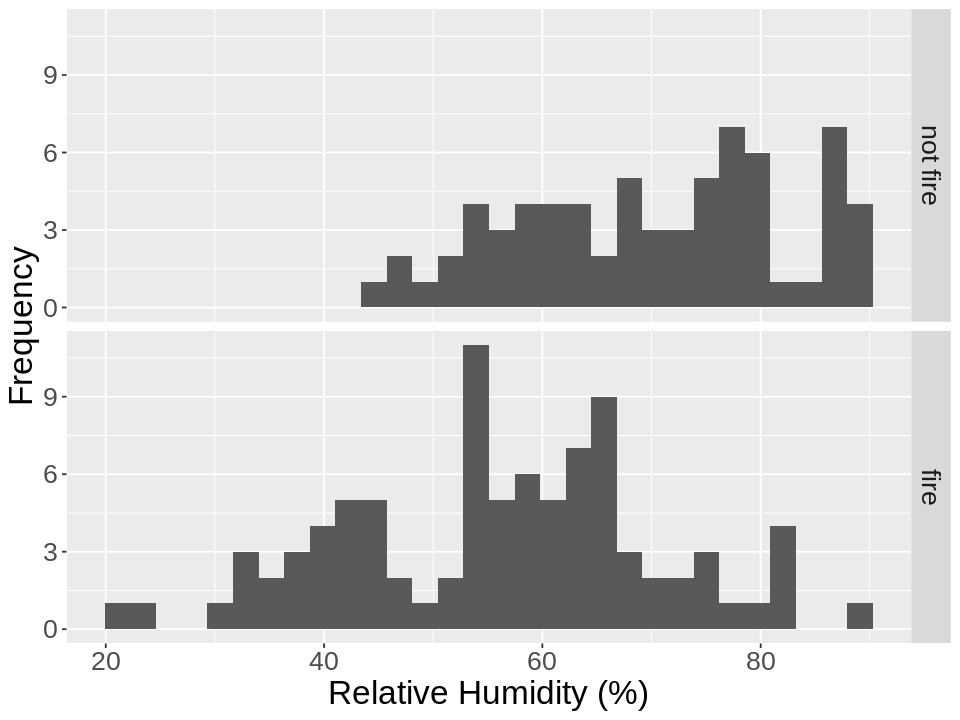

In [36]:
## Plot distribution of 'relative humidity' predictor on days with and without fire

RH_distribution_plot_fire <- forest_fire_train %>%
    ggplot(aes(x = RH)) +
    geom_histogram() +
    labs(x = "Relative Humidity (%)", y = "Frequency") +
    facet_grid(Classes ~ .) +
    theme(text = element_text(size = 20))

RH_distribution_plot_fire

In this histogram, we plot relative humidity on the x-axis and frequency on the y-axis. The observations in the "not fire" class seem to have consistently higher relative humidity, whereas relative humidity varies greatly among observations in the "fire" class. This could be a target for prediction, although it would not be entirely reliable because the ranges overlap at higher humidities.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



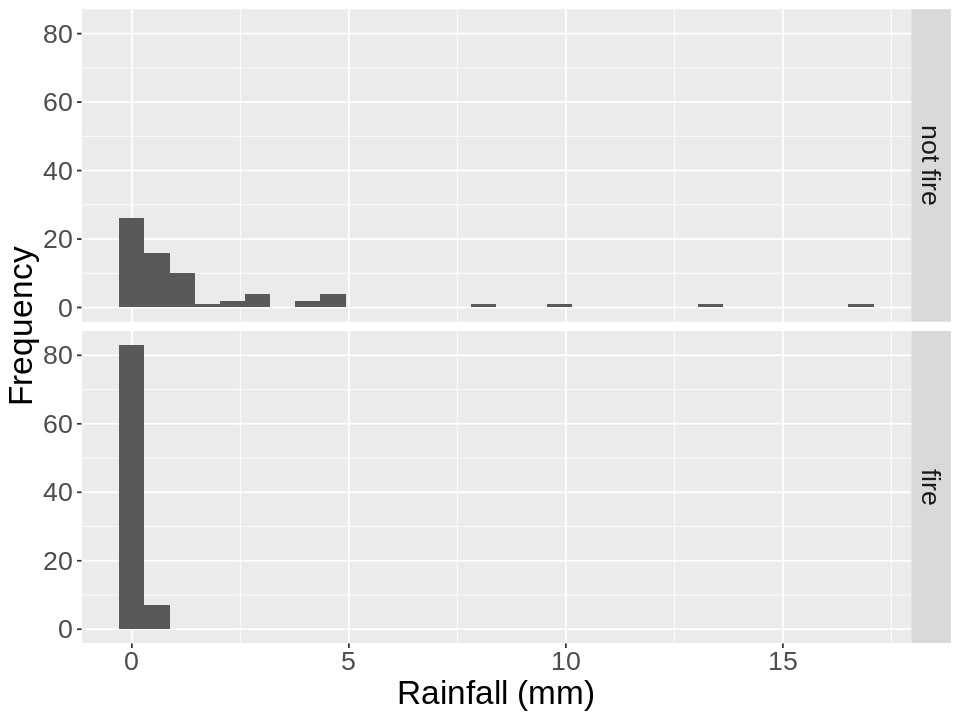

In [37]:
## Plot distribution of 'rainfall' predictor on days with and without fire

rain_distribution_plot_fire <- forest_fire_train %>%
    ggplot(aes(x = Rain)) +
    geom_histogram() +
    labs(x = "Rainfall (mm)", y = "Frequency") +
    facet_grid(Classes ~ .) +
    theme(text = element_text(size = 20))

rain_distribution_plot_fire

This histogram shows rainfall on the x-axis and frequency on the y-axis. The observations for "fire" have a very small spread, with the vast majority of observations having 0 rainfall. Variation in rainfall is larger for the "not fire" class, and expectedly, a few of these days experienced much more rain than the rest.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



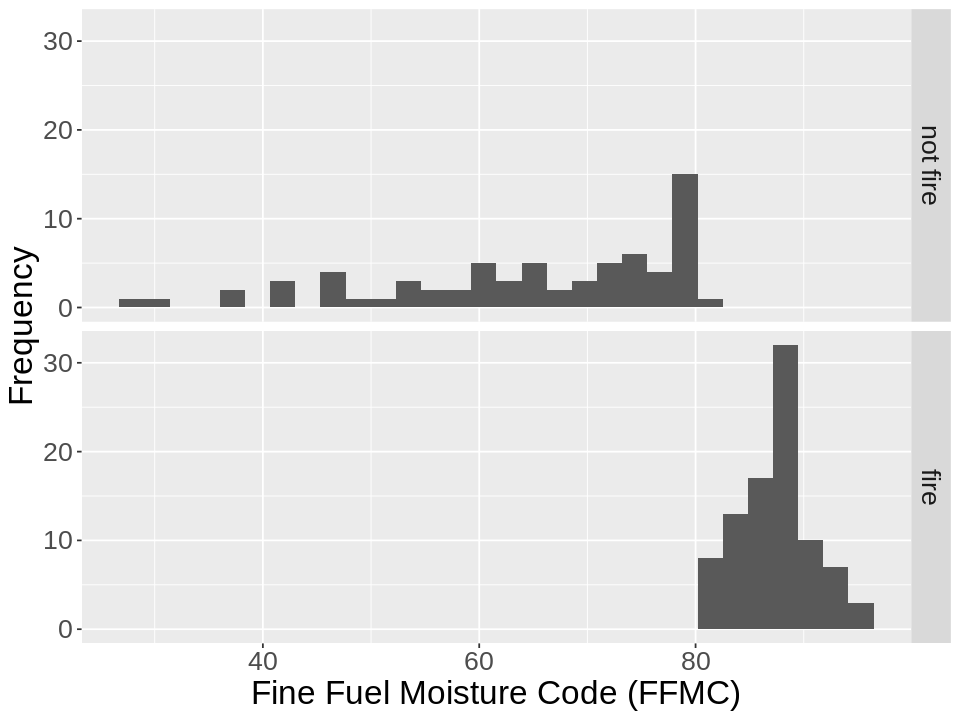

In [38]:
## Plot distribution of 'Fine Fuel Moisture Code' predictor on days with and without fire

FFMC_distribution_plot_fire <- forest_fire_train %>%
    ggplot(aes(x = FFMC)) +
    geom_histogram() +
    labs(x = "Fine Fuel Moisture Code (FFMC)", y = "Frequency") +
    facet_grid(Classes ~ .) +
    theme(text = element_text(size = 20))

FFMC_distribution_plot_fire

Finally, we create a histogram with FFMC on the x-axis and frequency on the y-axis. The FFMC values for "not fire" are distributed between 0 and approximately 80, with higher frequency at larger FFMC values. Meanwhile, all FFMC values for "fire" are greater than 80. Thus, it appears that FFMC could be particularly indicative of an observation's class.

Before conducting our analysis, we are also interested in trends that appear when more than one predictor variable is used to differentiate an observation's class. We picked three combinations of predictors to explore: FFMC vs temperature, rainfall vs temperature, and rainfall vs humidity.

In [39]:
options(repr.plot.width = 7, repr.plot.height = 6)

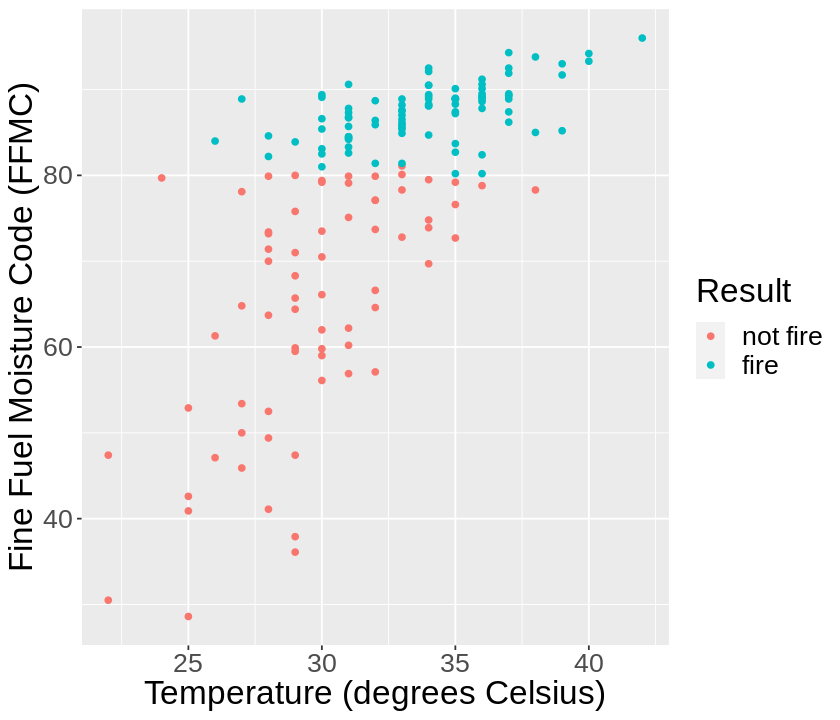

In [40]:
## Plot Fine Fuel Moisture Code vs temperature; points coloured by whether or not there was a fire

temp_v_ffmc <- forest_fire_train %>%
    ggplot(aes(x = Temperature, y = FFMC, color = Classes)) + 
    geom_point() +
    labs (x = "Temperature (degrees Celsius)", y = "Fine Fuel Moisture Code (FFMC)", color = "Result") + #weird title for color
    theme(text = element_text(size = 20))

temp_v_ffmc

Above, we create a scatterplot with temperature on the x-axis and FFMC on the y-axis, colouring the points by their classification. The plot shows a moderately strong positive linear relationship, with observations classified as "fire" located at higher temperature and FFMC values. A horizontal line at FFMC = 80 distinctly separates the two classes.

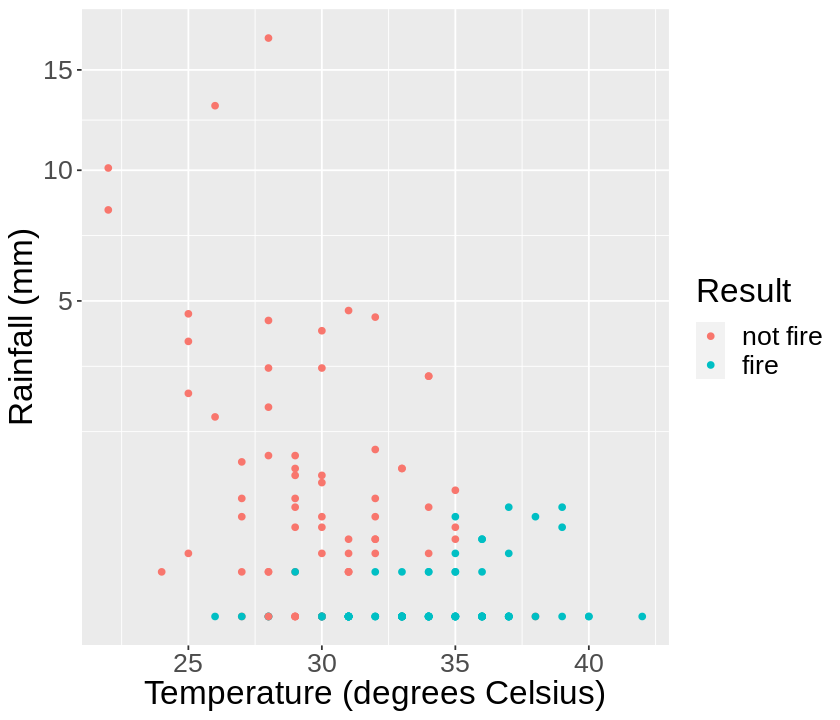

In [41]:
## Plot rainfall vs temperature; points coloured by whether or not there was a fire

# Use a square root scale because the majority of rainfall observations are less than 5
temp_v_rain <- forest_fire_train %>%
    ggplot(aes(x = Temperature, y = Rain, color = Classes)) + 
    geom_point() +
    scale_y_sqrt() +
    labs (x = "Temperature (degrees Celsius)", y = "Rainfall (mm)", color = "Result") + #weird title for color
    theme(text = element_text(size = 20))

temp_v_rain

Next, we plot temperature on the x-axis and rainfall on the y-axis, colouring the points by their classification. The plot shows a weak negative relationship between rainfall and temperature. In particular, there is a moderately clear boundary between classes; the "fire" class is a cluster of observations with high temperature and low rainfall in the lower right.

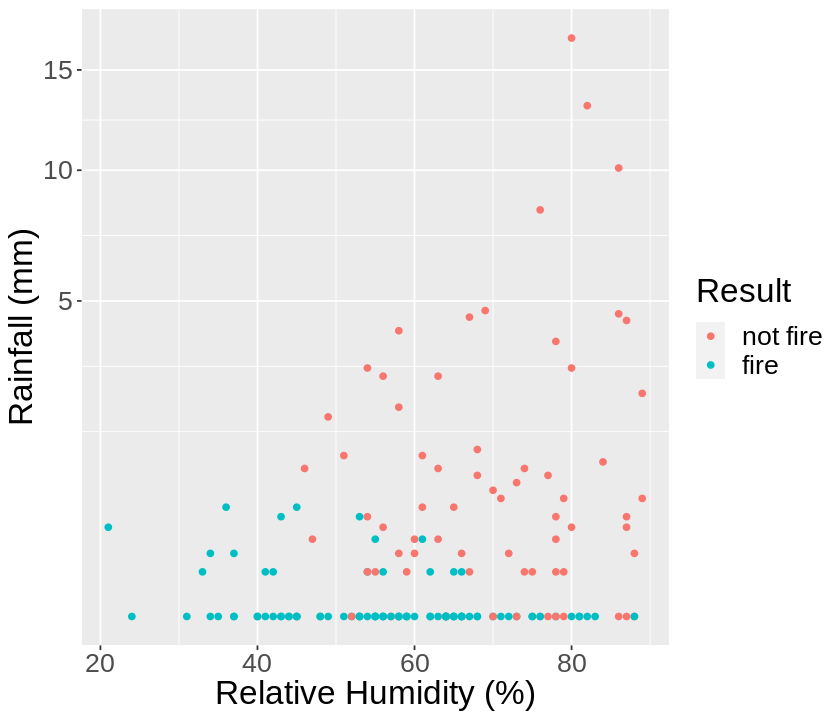

In [42]:
## Plot rainfall vs relative humidity; points coloured by whether or not there was a fire

# Use a square root scale because the majority of rainfall observations are less than 5
humidity_v_rain <- forest_fire_train %>%
    ggplot(aes(x = RH, y = Rain, color = Classes)) + 
    geom_point() +
    scale_y_sqrt() +
    labs (x = "Relative Humidity (%)", y = "Rainfall (mm)", color = "Result") + #weird title for color
    theme(text = element_text(size = 20))

humidity_v_rain

This scatterplot plots relative humidity on the x-axis and rainfall on the y-axis. There is a weak positive relationship between them. In particular, most of the observations with high rainfall and high humidity are in the "not fire" class, indicating a possible boundary that can be used for prediction.

Methods

Expected outcomes and significance